# Data Cleaning, EDA and Models
This notebook imports collected data from my selected subreddits and performs cleaning and EDA. Intital Models are built and tested.

## Imports

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

## Read in the data

In [2]:
unresolved = pd.read_csv('../data/unresolved.csv').drop(columns='Unnamed: 0')
#unresolved['subreddit'] = 'unresolved'
unresolved.head(2)

,author,awarders,created_utc,selftext,subreddit,title
0,TheBonesOfAutumn,[],1643236773,"On April 8th, 1981, 19-year-old David Huff dec...",UnresolvedMysteries,"In April of 1981, the body of 23-year-old Shar..."
1,Skoodilypoop666,[],1643233541,"In the fall of 2021, The small town of London ...",UnresolvedMysteries,“Whodunnit” the murder of 62 year old Bryan Mc...


In [3]:
unsolved = pd.read_csv('../data/unsolved.csv').drop(columns='Unnamed: 0')
#unsolved['subreddit'] = 'unsolved'
unsolved.head(2)

,author,awarders,created_utc,selftext,subreddit,title
0,amkakis,[],1643239264,NaN,UnsolvedMysteries,An 18 year old leaves home to retrieve a purse...
1,Once_a_TQ,[],1643227462,NaN,UnsolvedMysteries,Search continues for retired Cape Breton veter...


In [4]:
unsolved['selftext'].isna().sum()

1090

In [5]:
unsolved['awarders'].value_counts()

[]    1099
Name: awarders, dtype: int64

In [6]:
unresolved['awarders'].value_counts()

[]    1009
Name: awarders, dtype: int64

**'selftext' empty in UnsolvedMysteries posts, will focus on title only for now.**

## Data Cleaning

### Concat/Merge Data
Drop 'selftext', 'awarders' columns from both datasets and merge/concat them together

In [7]:
unsolved = unsolved.drop(columns=['awarders', 'selftext'])
unresolved = unresolved.drop(columns=['awarders', 'selftext'])

In [8]:
data = pd.concat([unsolved, unresolved], ignore_index=True)
data.head()

,author,created_utc,subreddit,title
0,amkakis,1643239264,UnsolvedMysteries,An 18 year old leaves home to retrieve a purse...
1,Once_a_TQ,1643227462,UnsolvedMysteries,Search continues for retired Cape Breton veter...
2,lexx999,1643224623,UnsolvedMysteries,"On December 31 2021, around 01:50, every trace..."
3,lexx999,1643224227,UnsolvedMysteries,"On December 31 2021, around 01:50, every trace..."
4,010010100100011001,1643216812,UnsolvedMysteries,McMartin Preschool Satanic abuse: 20-minute pr...


In [9]:
data.shape

(2108, 4)

### Drop duplicates

In [10]:
data.duplicated().sum()

1

In [11]:
data = data.drop_duplicates()

### Binarize target variable
UnresolvedMysteries == 1

UnsolvedMysteries == 0

In [12]:
data['subreddit'] = data['subreddit'].map(
    {
        'UnresolvedMysteries': 1,
        'UnsolvedMysteries': 0,
    }
)
data.head(2)

,author,created_utc,subreddit,title
0,amkakis,1643239264,0,An 18 year old leaves home to retrieve a purse...
1,Once_a_TQ,1643227462,0,Search continues for retired Cape Breton veter...


## EDA

### Let's add a length and word count based on title and examine distributions.

In [13]:
data['title_len'] = data['title'].str.len()

In [14]:
data['title_count'] = data['title'].map(lambda x: len(x.split()))

### Add a sentiment score using TextBlob

In [15]:
# Add polarity
data['title_polarity'] = data['title'].map(lambda x: TextBlob(x).sentiment[0])

In [16]:
# Add subjectivity
data['title_subjectivity'] = data['title'].map(lambda x: TextBlob(x).sentiment[1])

In [17]:
# Sanity check
data.head(2)

,author,created_utc,subreddit,title,title_len,title_count,title_polarity,title_subjectivity
0,amkakis,1643239264,0,An 18 year old leaves home to retrieve a purse...,107,21,0.1,0.200
1,Once_a_TQ,1643227462,0,Search continues for retired Cape Breton veter...,67,10,-0.1,0.025


### Full data pairplot

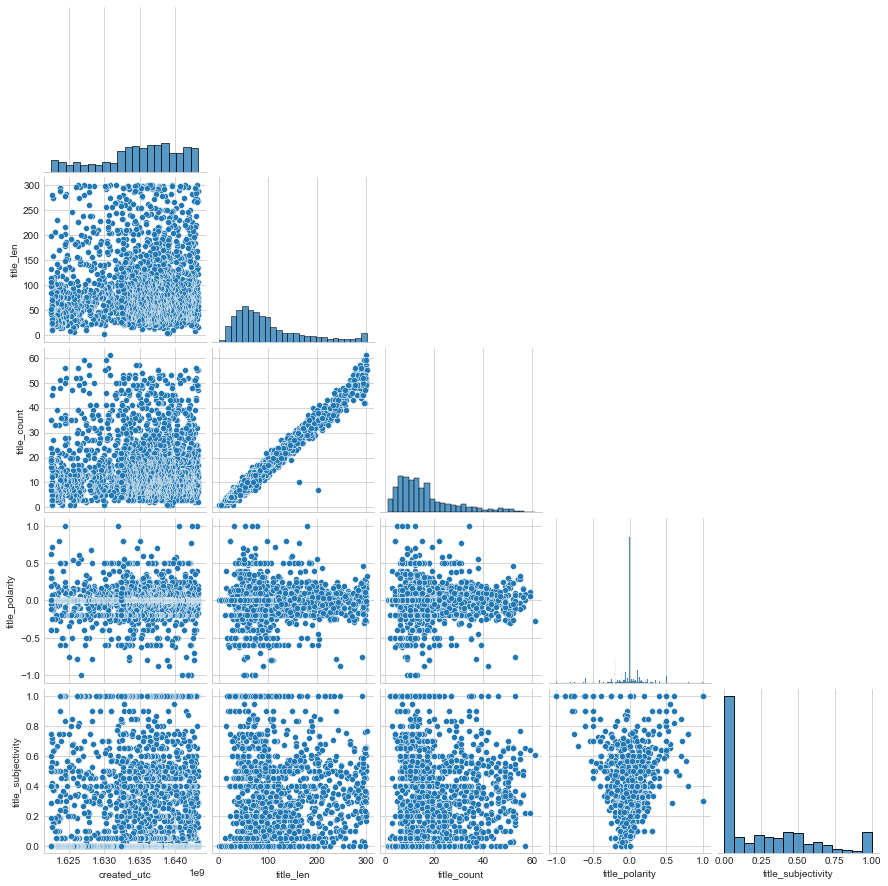

In [18]:
# With help from: https://github.com/matplotlib/ipympl/issues/25
plt.style.use(['seaborn-whitegrid'])
sns.pairplot(data.drop(columns='subreddit'), corner=True);

There are two outliers where title length doesn't align with title count. Nothing alarming though.

Title length and title count both appear normally distributed with right tail skew, which is expected: Mostly normal posts with some having longer titles.

It appears there is very little polarity and subjectivity in the titles, with some outliers. Will keep them just in case.


Let's run two more pairplots, one for each subreddit.

### UnresolvedMysteries pairplot

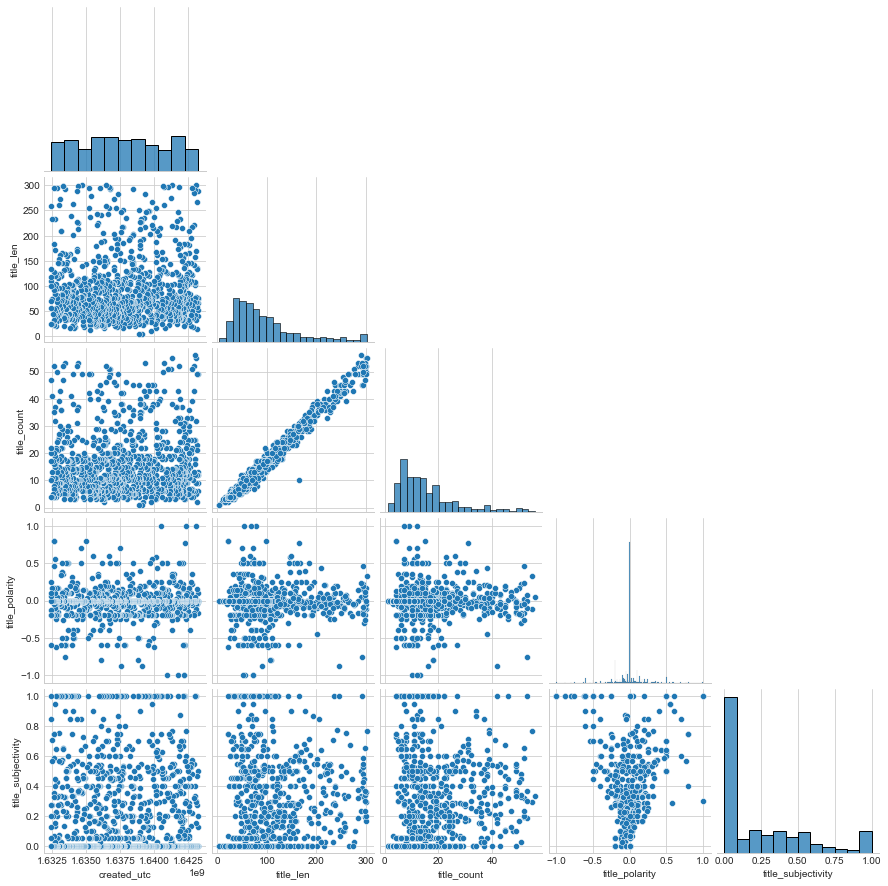

In [19]:
# With help from: https://github.com/matplotlib/ipympl/issues/25
plt.style.use(['seaborn-whitegrid'])
sns.pairplot(data[data['subreddit'] == 1].drop(columns='subreddit'), corner=True);

### UnsolvedMysteries pairplot

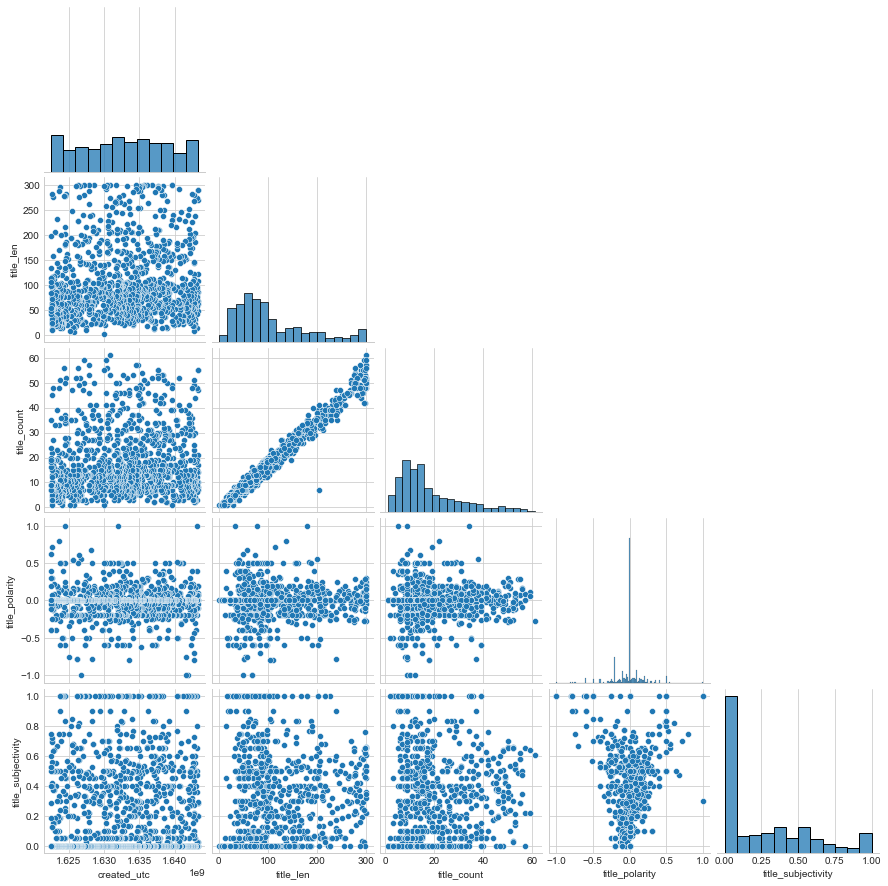

In [20]:
# With help from: https://github.com/matplotlib/ipympl/issues/25
plt.style.use(['seaborn-whitegrid'])
sns.pairplot(data[data['subreddit'] == 0].drop(columns='subreddit'), corner=True);

### EDA on the 'author' feature.

Let's check value counts to see if there are authors with many posts.

In [21]:
data['author'].value_counts()

HauntedSpy             114
[deleted]               40
AutoModerator           22
JustScratch9459         22
spiritoffff             22
                      ... 
jeremysbrain             1
jeffers0n_steelflex      1
Johnred5347              1
TrueCrime2202            1
woofwoofpack             1
Name: author, Length: 1251, dtype: int64

Now let's check for each subreddit.

In [22]:
data[data['subreddit'] == 0]['author'].value_counts()

HauntedSpy              114
spiritoffff              22
Particular-Intern-41     11
BitterRecover3379        11
MaddMysteries            11
                       ... 
Best_Needleworker_43      1
rodentfacedisorder        1
JourneyIntoTheMatrix      1
truecrimefan22            1
sjf-01                    1
Name: author, Length: 649, dtype: int64

In [23]:
data[data['subreddit'] == 1]['author'].value_counts()

[deleted]               30
JustScratch9459         22
AutoModerator           22
Main_Initiative         20
MistressGravity         11
                        ..
I_try_2271               1
ItsDrake2000             1
thatplantistoxic         1
AlteredSportsHistory     1
woofwoofpack             1
Name: author, Length: 635, dtype: int64

There are deleted authors, let's check how many those are.

In [24]:
data[data['author'] == '[deleted]'].shape

(40, 8)

Not many deleted authors and it does appear that some authors post consistently to a specific subreddit.

>Could go back to data collection and filter out posts with deleted author.

### Summary Statistics

In [25]:
data.describe()

,created_utc,subreddit,title_len,title_count,title_polarity,title_subjectivity
count,2.107000e+03,2107.000000,2107.000000,2107.000000,2107.000000,2107.000000
mean,1.635176e+09,0.478405,99.335548,16.843854,-0.015978,0.255522
std,5.428918e+06,0.499652,69.133024,12.282324,0.206963,0.306276
min,1.622510e+09,0.000000,1.000000,1.000000,-1.000000,0.000000
25%,1.632448e+09,0.000000,50.000000,8.000000,-0.066667,0.000000
50%,1.635985e+09,0.000000,79.000000,13.000000,0.000000,0.100000
75%,1.639200e+09,1.000000,126.000000,22.000000,0.000000,0.454545
max,1.643239e+09,1.000000,301.000000,61.000000,1.000000,1.000000


### EDA notes

The data seems to be fairly balanced and the numerical predictors are normally distributed. It appears this is a good dataset to use NLP and attempt to correctly classify the subreddit based on the words in the title of each post.

## Preprocessing

### Train-Test split
Start with 'title' only to build our baseline and first models

In [26]:
X = data['title']
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1331)

### Baseline model
Count Vectorizer and Dummy Classifier

In [27]:
cv = CountVectorizer()
X_train_transformed = cv.fit_transform(X_train)
X_test_transfomed = cv.transform(X_test)

In [28]:
null_model = DummyClassifier()
null_model.fit(X_train_transformed, y_train)
null_model.score(X_test_transfomed, y_test)

0.5218216318785579

In [29]:
y_test.value_counts(normalize=True)

0    0.521822
1    0.478178
Name: subreddit, dtype: float64

### Baseline model for 'author'
Count Vectorizer and Dummy Classifier

In [30]:
X_auth = data['author']
y_auth = data['subreddit']

X_train_auth, X_test_auth, y_train_auth, y_test_auth = train_test_split(X_auth, y_auth, stratify=y_auth, random_state=1331)

In [31]:
cv = CountVectorizer()
X_train_auth_transformed = cv.fit_transform(X_train_auth)
X_test_auth_transfomed = cv.transform(X_test_auth)

In [32]:
null_model = DummyClassifier()
null_model.fit(X_train_auth_transformed, y_train_auth)
null_model.score(X_test_auth_transfomed, y_test_auth)

0.5218216318785579

In [33]:
y_test_auth.value_counts(normalize=True)

0    0.521822
1    0.478178
Name: subreddit, dtype: float64

## Models

### Naive Bayes and CountVectorizer Pipeline. Initial score: 64.71% accuracy

In [34]:
pipe = make_pipeline(CountVectorizer(), MultinomialNB())

In [35]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6470588235294118

### LogisticRegression and CountVectorizer Pipeline.

In [36]:
pipe2 = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=1_000))

In [37]:
pipe2.fit(X_train, y_train)
pipe2.score(X_test, y_test)

0.6546489563567363

Initial score without adjusting any hyper parameters is not great: 64.71% accuracy using Naive Bayes, and 65.46% using LogisticRegression. Let's tune some parameters using GridSearchCV to see if we can improve the score.

### GridSearchCV on CountVectorizer and MultinomialNB, using title feature.

In [38]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'countvectorizer', 'multinomialnb', 'countvectorizer__analyzer', 'countvectorizer__binary', 'countvectorizer__decode_error', 'countvectorizer__dtype', 'countvectorizer__encoding', 'countvectorizer__input', 'countvectorizer__lowercase', 'countvectorizer__max_df', 'countvectorizer__max_features', 'countvectorizer__min_df', 'countvectorizer__ngram_range', 'countvectorizer__preprocessor', 'countvectorizer__stop_words', 'countvectorizer__strip_accents', 'countvectorizer__token_pattern', 'countvectorizer__tokenizer', 'countvectorizer__vocabulary', 'multinomialnb__alpha', 'multinomialnb__class_prior', 'multinomialnb__fit_prior'])

In [39]:
params = {
    'countvectorizer__min_df': [1, 2, 3],
    'countvectorizer__max_df': [.5, .7],
    'countvectorizer__ngram_range': [(1, 1), (1, 2)],
    'multinomialnb__alpha': [.1, 2]
}

In [40]:
gs = GridSearchCV(pipe, params, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
print(gs.score(X_test, y_test))

0.6487341772151899
{'countvectorizer__max_df': 0.5, 'countvectorizer__min_df': 1, 'countvectorizer__ngram_range': (1, 2), 'multinomialnb__alpha': 2}
0.650853889943074


Hardly any improvement. Let's try a model using the author feature

### Logistic Regression on 'author' feature.

In [61]:
X = data['author']
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1331)

In [62]:
pipe3 = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=1_000))

In [63]:
pipe3.fit(X_train, y_train)
pipe3.score(X_test, y_test)

0.7514231499051234

Now that's a notable improvement using a basic model. It confirms some intuitions about certain people being regular posters to specific subreddits.

### Decision Tree

In [64]:
pipe4 = make_pipeline(CountVectorizer(), DecisionTreeClassifier())

In [65]:
pipe4.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'countvectorizer', 'decisiontreeclassifier', 'countvectorizer__analyzer', 'countvectorizer__binary', 'countvectorizer__decode_error', 'countvectorizer__dtype', 'countvectorizer__encoding', 'countvectorizer__input', 'countvectorizer__lowercase', 'countvectorizer__max_df', 'countvectorizer__max_features', 'countvectorizer__min_df', 'countvectorizer__ngram_range', 'countvectorizer__preprocessor', 'countvectorizer__stop_words', 'countvectorizer__strip_accents', 'countvectorizer__token_pattern', 'countvectorizer__tokenizer', 'countvectorizer__vocabulary', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_we

I've tried different values for the decissiontreeclassifier__max_depth param and iterating to see the best score changes

In [77]:
params = {
    'decisiontreeclassifier__max_depth': [800]
}

In [78]:
gs4 = GridSearchCV(pipe4, params, n_jobs=-1)
gs4.fit(X_train, y_train)
print(gs4.best_score_)
print(gs4.best_params_)
print(gs4.score(X_test, y_test))

0.6841772151898734
{'decisiontreeclassifier__max_depth': 800}
0.7305502846299811


### Bagging

In [79]:
pipe5 = make_pipeline(CountVectorizer(), BaggingClassifier())

In [80]:
pipe5.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'countvectorizer', 'baggingclassifier', 'countvectorizer__analyzer', 'countvectorizer__binary', 'countvectorizer__decode_error', 'countvectorizer__dtype', 'countvectorizer__encoding', 'countvectorizer__input', 'countvectorizer__lowercase', 'countvectorizer__max_df', 'countvectorizer__max_features', 'countvectorizer__min_df', 'countvectorizer__ngram_range', 'countvectorizer__preprocessor', 'countvectorizer__stop_words', 'countvectorizer__strip_accents', 'countvectorizer__token_pattern', 'countvectorizer__tokenizer', 'countvectorizer__vocabulary', 'baggingclassifier__base_estimator', 'baggingclassifier__bootstrap', 'baggingclassifier__bootstrap_features', 'baggingclassifier__max_features', 'baggingclassifier__max_samples', 'baggingclassifier__n_estimators', 'baggingclassifier__n_jobs', 'baggingclassifier__oob_score', 'baggingclassifier__random_state', 'baggingclassifier__verbose', 'baggingclassifier__warm_start'])

I've tried different values for the decissiontreeclassifier__max_depth param and iterating to see the best score changes

In [83]:
params = {
    'baggingclassifier__n_estimators': range(1, 20),
    'baggingclassifier__n_jobs': [-1]
}

In [84]:
gs5 = GridSearchCV(pipe5, params, n_jobs=-1)
gs5.fit(X_train, y_train)
print(gs5.best_score_)
print(gs5.best_params_)
print(gs5.score(X_test, y_test))

0.700632911392405
{'baggingclassifier__n_estimators': 15, 'baggingclassifier__n_jobs': -1}
0.7286527514231499
